In [1]:
import os
import tellurium as te
import numpy as np
import pygmo as pg
import matplotlib.pyplot as plt

# some SBML model
modelfile = 'https://www.ebi.ac.uk/biomodels/services/download/get-files/MODEL6615119181/2/BIOMD0000000010_url.xml'

r = te.loadSBMLModel(modelfile)
r = te.loadSBMLModel(r.getParamPromotedSBML(r.getSBML()))

bin_model = 'model.b'
r.saveState(bin_model)
r.exportToSBML('model.sbml')

parameter_values = r.getGlobalParameterValues()

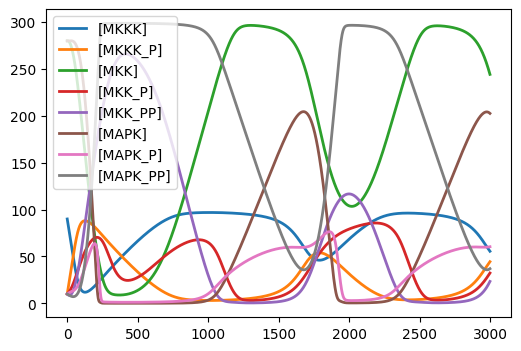

In [2]:
new_parameter_values = parameter_values*np.random.uniform(0, 1, len(parameter_values))
r.model.setGlobalParameterValues(parameter_values)

result = r.simulate(0, 3000, 5000)
r.reset()
r.plot(result)

In [139]:
class SBMLGlobalFit:

    def __init__(self, model, data, parameters, settings):
        self.model = model
        self.data = data
        self.parameters = parameters
        self.settings = settings
        self.upperb = [i*10 for i in parameters]
        self.lowerb = [i/10 for i in parameters]

    def fitness(self, x):
        from roadrunner import Config
        Config.setValue(Config.ROADRUNNER_DISABLE_PYTHON_DYNAMIC_PROPERTIES, False)
        Config.setValue(Config.LOADSBMLOPTIONS_RECOMPILE, False) 
        Config.setValue(Config.LLJIT_OPTIMIZATION_LEVEL, 4)

        r = te.loadSBMLModel(self.model)
        r.model.setGlobalParameterValues(x)
        
        try:
            results = r.simulate(0, 3000, 5000)[:,1:].__array__()
        except:
            results = self.data*0
        return self._residual(results,self.data)

    # def _residual(self,results,data,points):
    #     md = (np.nanmax(data,1,keepdims=True)-np.nanmin(data,1,keepdims=True))/2
    #     mr = (np.nanmax(results,1,keepdims=True)-np.nanmin(results,1,keepdims=True))/2
    #     denom = np.ones(data.shape)
    #     return [np.nansum(((data-results)/(points*(md**2+mr**2)**0.5*denom))**2)]
    def _residual(self,results,data):
        cols = self.settings['fit_to_cols']
        rows = self.settings['fit_to_rows']
        return [np.nansum(np.abs(data[:,cols][rows,:]-results[:,cols][rows,:]))]

    def get_bounds(self):
        return (self.lowerb, self.upperb)
    
    def get_name(self):
        return 'Global Fitting of Multiple SBML Models'

    def gradient(self, x):
        return pg.estimate_gradient_h(lambda x: self.fitness(x),x)


In [140]:
udi = pg.ipyparallel_island()
udi.init_view(client_kwargs={'profile':'cheme-ecfers'})

udbfe = pg.ipyparallel_bfe()
udbfe.init_view(client_kwargs={'profile':'cheme-ecfers'})

a = pg.pso_gen(gen=10)
a.set_bfe(pg.bfe(udbfe))
algo = pg.algorithm(a)
algo.set_verbosity(1)

# pick a number of data points to fit to
settings = {'fit_to_cols':list(np.random.choice(r.getNumFloatingSpecies(),(r.getNumFloatingSpecies()//4),replace=False))}
settings['fit_to_rows'] = list(map(int, np.linspace(0,5000-1,10)))

prob = pg.problem(SBMLGlobalFit(model = '/gscratch/cheme/dalba/repos/ECFERS/models/MODEL6615119181.sbml', data = result[:,1:].__array__(), parameters=parameter_values, settings=settings))

In [150]:
archi = pg.archipelago(n=10,t=pg.ring(), algo=algo, prob=prob, pop_size=100, udi = udi, b = udbfe, r_pol = pg.fair_replace(0.0), s_pol = pg.select_best(0.0))
res =  []
for i in range(100):
    archi.evolve()
    archi.wait_check()
    res.append(np.array([a.get_algorithm().extract(pg.pso_gen).get_log()for a in archi]))
results = np.concatenate(res,axis=1)

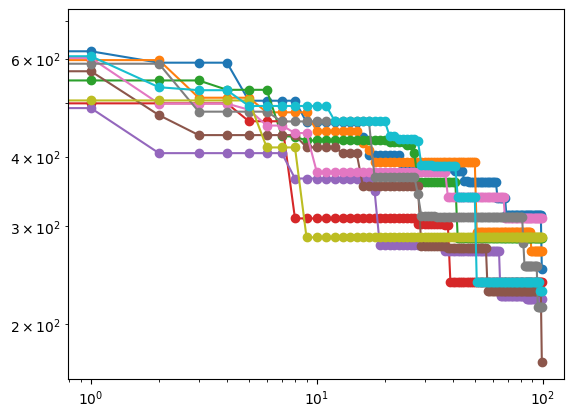

In [142]:
plt.plot(results[:,:,2].T,'o-')
plt.xscale('log')
plt.yscale('log')

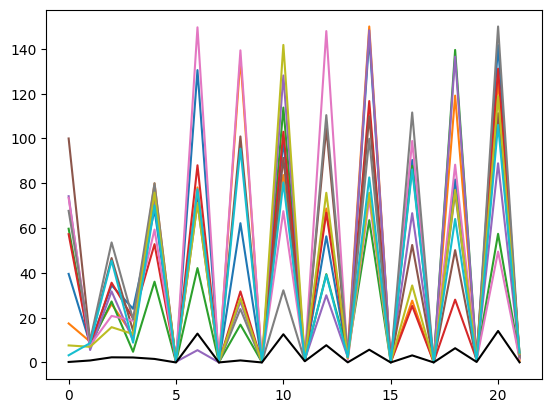

In [143]:
plt.plot(np.array(archi.get_champions_x()).T)
plt.plot(new_parameter_values,'k')

Text(0, 0.5, 'concentraion')

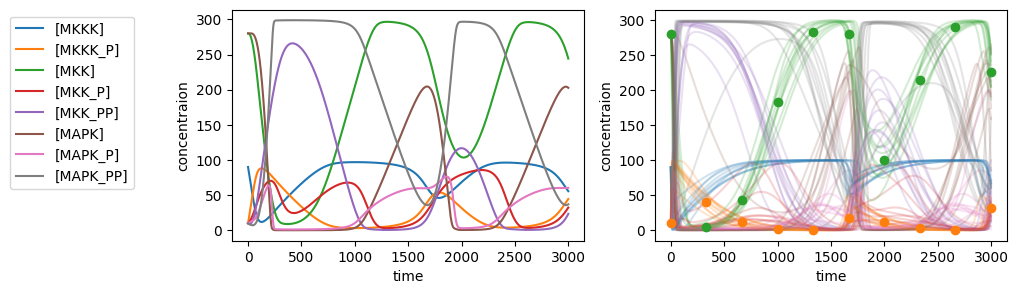

In [149]:
colors = [u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#d62728', u'#9467bd', u'#8c564b', u'#e377c2', u'#7f7f7f', u'#bcbd22', u'#17becf']
plt.figure(figsize=(10,3))
a = plt.subplot(1,2,1)
a.plot(result['time'],result[:,1:].__array__())
a.legend(result.colnames[1:], bbox_to_anchor=(-0.65, 1), loc='upper left' )
a.set_xlabel('time')
a.set_ylabel('concentraion')

b = plt.subplot(1,2,2)
mean_result = result*0
for c in archi.get_champions_x():
    r.model.setGlobalParameterValues(c)
    result2 = r.simulate(0, 3000, 5000)
    mean_result += result2
    r.reset()
    b.set_prop_cycle(color=colors)
    b.plot(result['time'], result2[:,1:].__array__(), alpha = 0.2)

b.set_prop_cycle(color = [colors[s] for s in settings['fit_to_cols']])
b.plot(result['time'][settings['fit_to_rows']], (mean_result[:,1:].__array__()/10)[:,settings['fit_to_cols']][settings['fit_to_rows'],:],'o')
b.set_xlabel('time')
b.set_ylabel('concentraion')